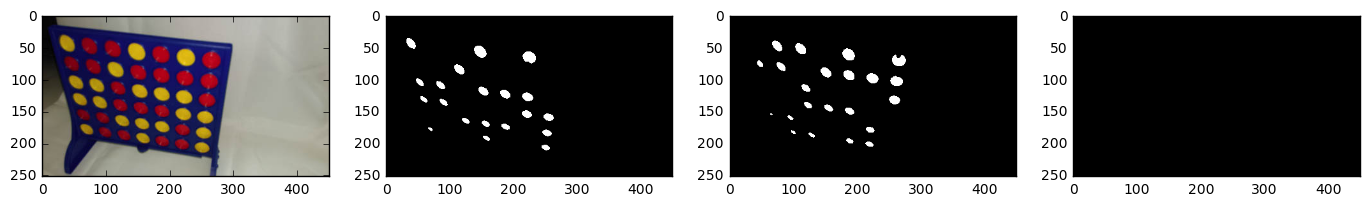

In [241]:
from skimage import io
from skimage.filters import gaussian, laplace, median
from skimage.morphology import disk
import matplotlib.pyplot as plt
import numpy as np

board = io.imread("board_images/board19.jpg") # values are optimised for images with a resolution of 450*252px

# reference colours
yellow = [193,155,17]
red = [156,10,25]
white = [150,148,138]
blue = [12,11,69]
tolerance = 50


# extract positions of the different game colours    
    
board_yellow = np.zeros_like(board[:,:,0])
for x in range(board.shape[0]):
    for y in range(board.shape[1]):
        if (np.all(np.fabs(board[x, y]-yellow) <= tolerance)): board_yellow[x,y] = 1
            
board_red = np.zeros_like(board[:,:,0])
for x in range(board.shape[0]):
    for y in range(board.shape[1]):
        if (np.all(np.fabs(board[x, y]-red) <= tolerance)): board_red[x,y] = 1       
            
board_white = np.zeros_like(board[:,:,0])
for x in range(board.shape[0]):
    for y in range(board.shape[1]):
        if (np.all(np.fabs(board[x, y]-white) <= tolerance) ): board_white[x,y] = 1             
        #and np.any(np.fabs(board[:x, :y]-blue) <= tolerance) and np.any(np.fabs(board[x:, :y]-blue) <= tolerance) and np.any(np.fabs(board[:x, y:]-blue) <= tolerance) and np.any(np.fabs(board[x:, y:]-blue) <= tolerance)

# optimisation of board_white: only count white pixels surrounded by blue ones, i.e. discard all pixels of the present board_white until a blue one is reached (from all four directions)
# TODO: This takes rather long (~10s) - think of a more efficient algorithm to extract white within the board
for x in range(board.shape[0]):
    # from top:
    for y in range(board.shape[1]):
        if (np.all(np.fabs(board[x, y]-blue) <= tolerance-20)): break
        else: board_white[x,y] = 0
    # from bottom:
    for y in range(board.shape[1]):
        if (np.all(np.fabs(board[x, board.shape[1]-y-1]-blue) <= tolerance-20)): break
        else: board_white[x, board.shape[1]-y-1] = 0
    
for y in range(board.shape[1]):    
    # from left:
    for x in range(board.shape[0]):
        if (np.all(np.fabs(board[x, y]-blue) <= tolerance-20)): break
        else: board_white[x,y] = 0
    # from right:
    for x in range(board.shape[0]):
        if (np.all(np.fabs(board[board.shape[0]-x-1, y]-blue) <= tolerance-20)): break
        else: board_white[board.shape[0]-x-1, y] = 0            


# add Gaussian smoothing            
board_yellow = gaussian(board_yellow, sigma=2)
board_red    = gaussian(board_red, sigma=2)
board_white  = gaussian(board_white, sigma=2)

# cut away low values below 95% brightness (i.e. increase contrast)
board_total = board_yellow + board_red + board_white
thresh = np.percentile(board_total, 95)
for board_current in [board_yellow, board_red, board_white]:
    for x in range(board_current.shape[0]):
        for y in range(board_current.shape[1]):
            if (board_current[x, y] < thresh): board_current[x, y] = 0
            else: board_current[x, y] = 1
            
plt.figure(figsize=(17, 5))
plt.subplot(141)
plt.imshow(board)
plt.subplot(142)
plt.imshow(board_yellow, cmap='gray')
plt.subplot(143)
plt.imshow(board_red, cmap='gray')
plt.subplot(144)
plt.imshow(board_white, cmap='gray')

plt.show()

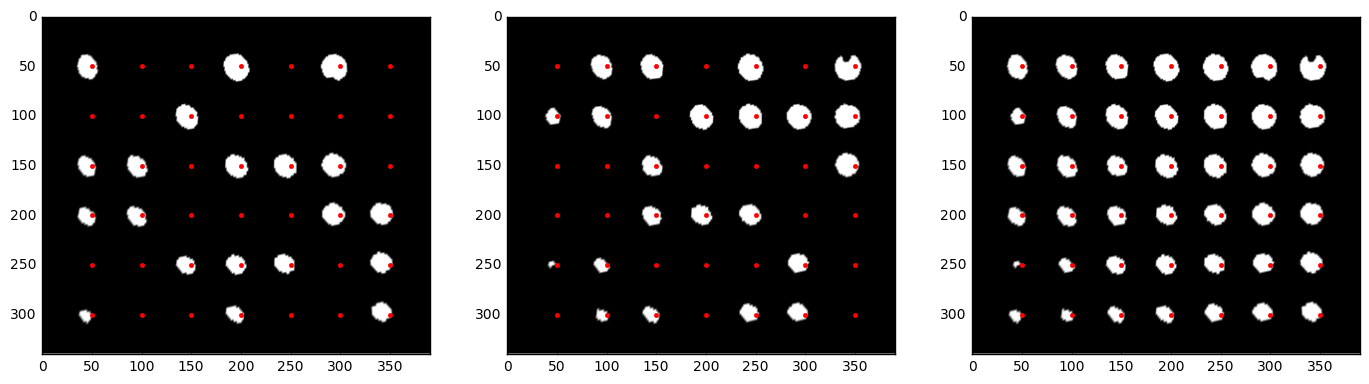

In [242]:
# transform to a square grid
from skimage import transform as tf

board_total = board_yellow+board_red+board_white

# mirror board against the y-axis
board_mirrored = np.copy(board_total)
for x in range(board_total.shape[0]):
    for y in range(board_total.shape[1]):
        board_mirrored[x, board_total.shape[1]-y-1] = board_total[x,y]
        
# for viewing angles which are not too steep, it should be sufficient to look for the bright points with smallest and biggest coordinate sum and treat these as top-left / bottom-right corner:
topleft = [board_total.shape[0], board_total.shape[1]]
for x in range(board_total.shape[0]):
    for y in range(board_total.shape[1]):
        if (board_total[x, y]>0 and x+y<topleft[0]+topleft[1]): 
            topleft[0] = x
            topleft[1] = y
# invert position of x- and y-coordinate in list (stupid thinking mistake, could be corrected in the actual loop)
topleft = topleft[ : :-1]

botright = [0, 0]
for x in range(board_total.shape[0]):
    for y in range(board_total.shape[1]):
        if (board_total[x, y]>0 and x+y>botright[0]+botright[1]): 
            botright[0] = x
            botright[1] = y
# invert position of x- and y-coordinate in list (stupid thinking mistake, could be corrected in the actual loop)
botright = botright[ : :-1]

# bottom-left and top-right can be obtained in the same way from the board which is mirrored on the y-axis:
topright = [board_mirrored.shape[0], board_mirrored.shape[1]]
for x in range(board_mirrored.shape[0]):
    for y in range(board_mirrored.shape[1]):
        if (board_mirrored[x, y]>0 and x+y<topright[0]+topright[1]): 
            topright[0] = x
            topright[1] = y
# invert mirroring
topright[1] = board_mirrored.shape[1]-topright[1]
# invert position of x- and y-coordinate in list (stupid thinking mistake, could be corrected in the actual loop)
topright = topright[ : :-1]

botleft = [0, 0]
for x in range(board_mirrored.shape[0]):
    for y in range(board_mirrored.shape[1]):
        if (board_mirrored[x, y]>0 and x+y>botleft[0]+botleft[1]): 
            botleft[0] = x
            botleft[1] = y
# invert mirroring
botleft[1] = board_mirrored.shape[1]-botleft[1]            
# invert position of x- and y-coordinate in list (stupid thinking mistake, could be corrected in the actual loop)
botleft = botleft[ : :-1]


# now, add constant margin and warp to square grid (image rectification using scikit-image):
margin = 40
dimensions = [350, 300] # this should be in the ratio 7:6 due to the board configuration

# src and dest are a bit counter-intuitive...  
src = np.array([[margin, margin], [margin, dimensions[1]], [dimensions[0], dimensions[1]], [dimensions[0], margin]])
dst = np.array([topleft,          botleft,                 botright,                       topright])

transf = tf.ProjectiveTransform()
transf.estimate(src, dst) # look for transformation transforming src to dst, i.e. the inverse transformation from dst to src
board_total_warped = tf.warp(board_total, transf, output_shape=(dimensions[1]+margin, dimensions[0]+margin))
board_yellow_warped = tf.warp(board_yellow, transf, output_shape=(dimensions[1]+margin, dimensions[0]+margin))
board_red_warped = tf.warp(board_red, transf, output_shape=(dimensions[1]+margin, dimensions[0]+margin))


# set up grid to extract colour information
grid = np.array([[50*(i+1), 50*(6-j)] for i in range(7) for j in range(6)])
        

plt.figure(figsize=(17,5))
plt.subplot(131)
plt.imshow(board_yellow_warped, cmap='gray')
plt.plot(grid[:,0], grid[:,1], '.r')
plt.xlim(0,dimensions[0]+margin)
plt.ylim(dimensions[1]+margin,0)
plt.subplot(132)
plt.imshow(board_red_warped, cmap='gray')
plt.plot(grid[:,0], grid[:,1], '.r')
plt.xlim(0,dimensions[0]+margin)
plt.ylim(dimensions[1]+margin,0)
plt.subplot(133)
plt.imshow(board_total_warped, cmap='gray')
plt.plot(grid[:,0], grid[:,1], '.r')
plt.xlim(0,dimensions[0]+margin)
plt.ylim(dimensions[1]+margin,0)
plt.show()

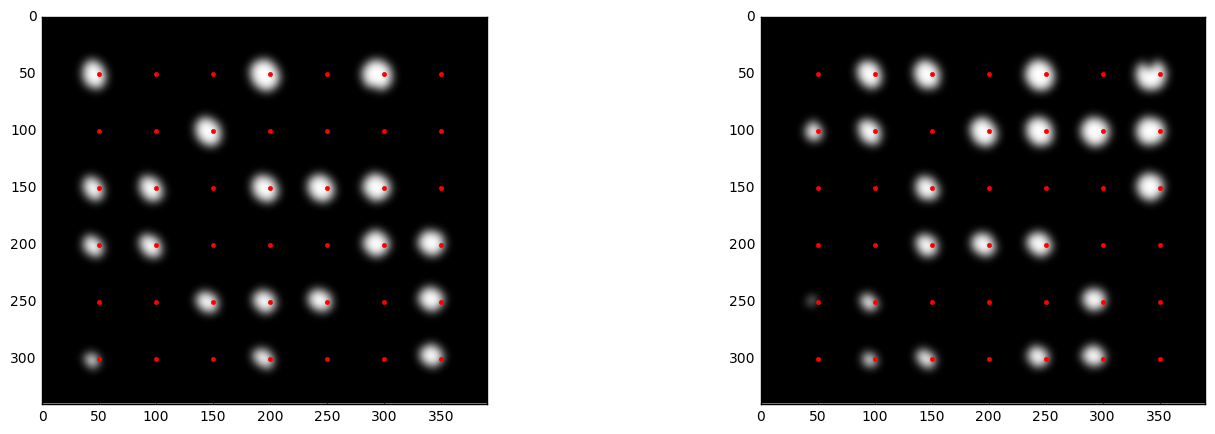

[[ 0.  2.  2.  0.  2.  2.  0.]
 [ 2.  2.  0.  0.  0.  2.  0.]
 [ 0.  0.  2.  2.  2.  0.  0.]
 [ 0.  0.  2.  0.  0.  0.  2.]
 [ 2.  2.  0.  2.  2.  2.  2.]
 [ 0.  2.  2.  0.  2.  0.  2.]]


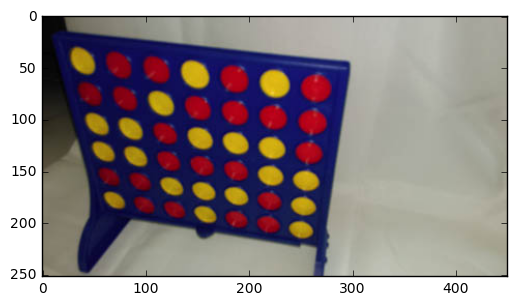

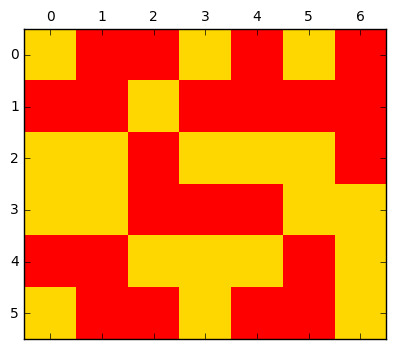

In [247]:
from matplotlib.colors import ListedColormap

# extract colour information
boardconfig = np.ones([6,7])                                                #1 for free slot (white)

# add an extra Gaussian smoothing in case the spots don't end up perfectly on the grid points:
board_yellow_warped_smoothed = gaussian(board_yellow_warped, sigma=4)
board_red_warped_smoothed    = gaussian(board_red_warped,    sigma=4)

plt.figure(figsize=(17,5))
plt.subplot(121)
plt.imshow(board_yellow_warped_smoothed, cmap='gray')
plt.plot(grid[:,0], grid[:,1], '.r')
plt.xlim(0,dimensions[0]+margin)
plt.ylim(dimensions[1]+margin,0)
plt.subplot(122)
plt.imshow(board_red_warped_smoothed, cmap='gray')
plt.plot(grid[:,0], grid[:,1], '.r')
plt.xlim(0,dimensions[0]+margin)
plt.ylim(dimensions[1]+margin,0)
plt.show()

for i, pos in enumerate(grid):
    if (board_yellow_warped_smoothed[pos[1], pos[0]] > 1e-6): boardconfig[i%6, i//6] = 0 #0 for yellow
    elif (board_red_warped_smoothed[pos[1], pos[0]]  > 1e-6): boardconfig[i%6, i//6] = 2 #2 for red
        
# draw board and original photograph for comparison:
colormap = ListedColormap(['gold', 'white', 'red'])
print(boardconfig)
plt.imshow(board)
plt.matshow(np.flipud(boardconfig), cmap=colormap)
plt.show()